In [39]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing;
from sklearn.model_selection import cross_validate as cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [40]:
import datetime
from datetime import timedelta
forecast_out = 365 #Days from now

stock_ticker ='NVDA'

end = datetime.datetime.now()#-timedelta(7) #remove timedetla -1 to go to productions mode
start = datetime.datetime.now()-timedelta(forecast_out)

# benchmark = web.DataReader(stock_ticker, 'yahoo', start, end )
stock = web.DataReader(stock_ticker, 'yahoo', start, end)


In [41]:
test_size=20
test_index = len(stock['Adj Close'])- test_size

In [42]:
train = stock['Adj Close'].iloc[:test_index]
test= stock['Adj Close'].iloc[test_index:]

In [43]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
scaler=MinMaxScaler()
scaler.fit(train.to_frame())
scaled_train = scaler.transform(train.to_frame())
scaled_test = scaler.transform(test.to_frame())

In [45]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [46]:
length=19
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=1)

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [48]:
n_features =1
model= Sequential()
# pretty good model at 200 epochs
# model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
# model.add(Dropout(0.2))
# model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [49]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [50]:
validation_generator= TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size =1)

In [51]:
# model.fit_generator(generator, epochs=20,
#                    validation_data=validation_generator, callbacks=[early_stop])
model.fit_generator(generator, epochs=200,
                   validation_data=validation_generator)

och 9/200
237/237 [==============================] - 2s 9ms/step - loss: 0.0102 - val_loss: 0.0030
Epoch 10/200
237/237 [==============================] - 2s 8ms/step - loss: 0.0086 - val_loss: 9.4586e-05
Epoch 11/200
237/237 [==============================] - 2s 8ms/step - loss: 0.0085 - val_loss: 0.0025
Epoch 12/200
237/237 [==============================] - 2s 10ms/step - loss: 0.0082 - val_loss: 0.0170
Epoch 13/200
237/237 [==============================] - 2s 9ms/step - loss: 0.0086 - val_loss: 0.0024
Epoch 14/200
237/237 [==============================] - 2s 9ms/step - loss: 0.0079 - val_loss: 0.0036
Epoch 15/200
237/237 [==============================] - 2s 9ms/step - loss: 0.0075 - val_loss: 0.0013
Epoch 16/200
237/237 [==============================] - 2s 8ms/step - loss: 0.0084 - val_loss: 0.0020
Epoch 17/200
237/237 [==============================] - 2s 8ms/step - loss: 0.0069 - val_loss: 0.0023
Epoch 18/200
237/237 [==============================] - 2s 10ms/step - loss: 0.0

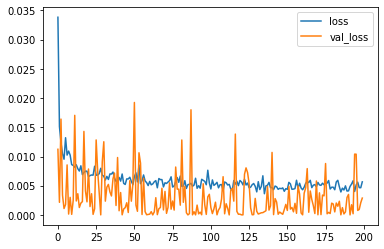

In [52]:
losses= pd.DataFrame(model.history.history)
ax =losses.plot()
plt.show()

In [53]:
test_predictions =[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [54]:
true_predictions =scaler.inverse_transform(test_predictions)


In [55]:
predictions = pd.DataFrame(test)
predictions['Predictions'] = true_predictions

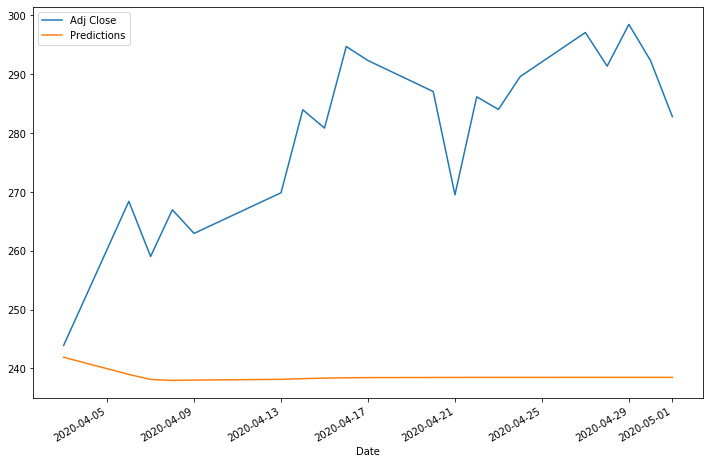

In [56]:
ax=predictions.plot(figsize=(12,8))
plt.show()

In [58]:
predictions

,Adj Close,Predictions
Date,,
2020-04-03,243.910004,241.900294
2020-04-06,268.399994,238.982090
2020-04-07,259.029999,238.134901
2020-04-08,266.950012,237.958976
2020-04-09,262.950012,238.027348
2020-04-13,269.850006,238.150732
2020-04-14,283.950012,238.267436
2020-04-15,280.839996,238.353947
2020-04-16,294.700012,238.410676


In [57]:
from keras.models import load_model
model.save(stock_ticker+'.h5')